# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [18]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open('capstone_websites_data/y_10users.pkl', 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 13 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [19]:
X_sparse_10users.shape

(13084, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=7 – для воспроизводимости.**

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [2]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [3]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).**

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [15]:
%%time
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)

Wall time: 3.05 s


In [21]:
knn_cv_scores.mean(), knn_cv_scores.std()

(0.53123051143725408, 0.0010331440593672654)

In [19]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [23]:
%%time
knn_valid_acc = accuracy_score(y_valid, knn.predict(X_valid))

Wall time: 3 s


In [24]:
knn_valid_acc

0.5560366785532348

**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [25]:
write_answer_to_file("{} {}".format(round(float(np.mean(knn_cv_scores)), 3), 
                                    round(knn_valid_acc, 3)),
                     'answer4_1.txt')

**2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=7). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
forest = RandomForestClassifier(n_estimators=100, random_state=7, oob_score=True)

In [29]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [30]:
forest.oob_score_

0.7029919196331077

In [31]:
rf_valid_acc = accuracy_score(y_valid, forest.predict(X_valid))
rf_valid_acc

0.71803362200713194

**Запишите в файл *answer4_2.txt* доли правильных ответов для RandomForestClassifier при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [32]:
write_answer_to_file("{} {}".format(round(forest.oob_score_, 3), round(rf_valid_acc, 3)),
                     'answer4_2.txt')

**3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [6]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [34]:
logit = LogisticRegression(random_state=7)

In [35]:
%%time
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1)

Wall time: 3min 11s


In [36]:
logit_cv_scores.mean()

0.73694924176249899

In [37]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
accuracy_score(y_valid, logit.predict(X_valid))

0.75700458481915434

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).**

**С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=7. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.**

**Нарисуйте кривые валидации по параметру С.**

In [40]:
%%time
logit_c_values1 = np.linspace(1e-4, 1e4, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=7, n_jobs=-1)

logit_grid_searcher1.fit(X_train, y_train)

Wall time: 16min 41s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [49]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[31].mean(axis=0)

In [60]:
logit_grid_searcher1.Cs_

array([  1.00000000e-04,   1.11111120e+03,   2.22222230e+03,
         3.33333340e+03,   4.44444450e+03,   5.55555560e+03,
         6.66666670e+03,   7.77777780e+03,   8.88888890e+03,
         1.00000000e+04])

In [50]:
logit_mean_cv_scores1

array([ 0.30017619,  0.72897586,  0.7272283 ,  0.71882344,  0.71772997,
        0.71423578,  0.71325203,  0.71139614,  0.71106824,  0.70975766])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [59]:
print(logit_mean_cv_scores1.max(), logit_grid_searcher1.Cs_[logit_mean_cv_scores1.argmax()])

0.728975856486 1111.1112


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

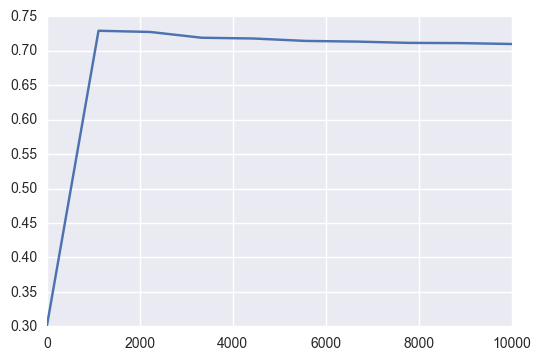

In [61]:
plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(1e-3, 1, 30). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [62]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 30)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, random_state=7, n_jobs=-1, multi_class='multinomial')

logit_grid_searcher2.fit(X_train, y_train)

Wall time: 22min 25s


In [162]:
logit_c_values2

array([ 0.001     ,  0.03544828,  0.06989655,  0.10434483,  0.1387931 ,
        0.17324138,  0.20768966,  0.24213793,  0.27658621,  0.31103448,
        0.34548276,  0.37993103,  0.41437931,  0.44882759,  0.48327586,
        0.51772414,  0.55217241,  0.58662069,  0.62106897,  0.65551724,
        0.68996552,  0.72441379,  0.75886207,  0.79331034,  0.82775862,
        0.8622069 ,  0.89665517,  0.93110345,  0.96555172,  1.        ])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [63]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[31].mean(axis=0)

In [64]:
logit_mean_cv_scores2

array([ 0.46942737,  0.68093402,  0.70462905,  0.71522013,  0.72046021,
        0.7250474 ,  0.72690325,  0.72887036,  0.73007125,  0.73138162,
        0.7319271 ,  0.7324737 ,  0.73334794,  0.73334708,  0.7336742 ,
        0.73389299,  0.73433015,  0.73487599,  0.73531247,  0.73498471,
        0.73563966,  0.73520279,  0.73563916,  0.73553055,  0.73553077,
        0.7354213 ,  0.73531204,  0.73563959,  0.73520265,  0.73509386])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [65]:
print(logit_mean_cv_scores2.max(), logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()])

0.735639662401 0.689965517241


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

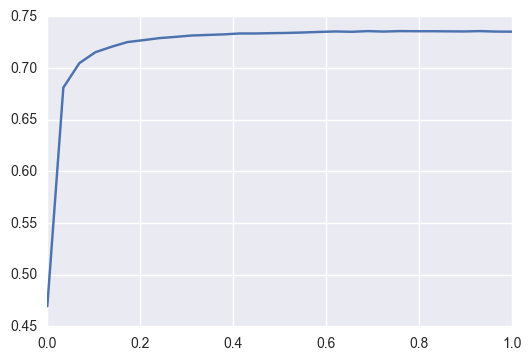

In [66]:
plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [67]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))

In [68]:
logit_cv_acc

0.75241976566479873

**Запишите в файл *answer4_3.txt* доли правильных ответов для logit_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [69]:
write_answer_to_file("{} {}".format(round(float(np.max(logit_mean_cv_scores2)), 3), 
                                    round(logit_cv_acc, 3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).**

In [13]:
from sklearn.svm import LinearSVC

In [14]:
svm = LinearSVC(C=1, random_state=7)

In [72]:
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)

In [73]:
svm_cv_scores.mean()

0.72668081181594324

In [74]:
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [76]:
accuracy_score(y_valid, svm.predict(X_valid))

0.75140091696383082

**С помощью GridSearchCV подберите параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [77]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 23 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [83]:
print(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_)

0.661825726141 {'C': 5555.5556000000006}


In [85]:
svm_grid_searcher1.cv_results_

{'mean_fit_time': array([ 0.05866671,  2.61733341,  2.59733327,  2.8379999 ,  2.76199992,
         3.27033329,  1.99766668,  3.13833332,  1.96533338,  2.21566661]),
 'mean_score_time': array([ 0.00133332,  0.00066662,  0.00100009,  0.00100009,  0.00100009,
         0.00100009,  0.00066662,  0.0006667 ,  0.00100001,  0.0006667 ]),
 'mean_test_score': array([ 0.52598821,  0.63583752,  0.64500983,  0.62895829,  0.65276261,
         0.66182573,  0.65636602,  0.61672854,  0.63529155,  0.64282594]),
 'mean_train_score': array([ 0.54236702,  0.84216651,  0.84777586,  0.836812  ,  0.85657378,
         0.85979674,  0.86072377,  0.81927895,  0.84297669,  0.84865805]),
 'param_C': masked_array(data = [0.0001 1111.1112000000001 2222.2223000000004 3333.3334000000004
  4444.4445000000005 5555.5556000000006 6666.6667000000007
  7777.7778000000008 8888.8888999999999 10000.0],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

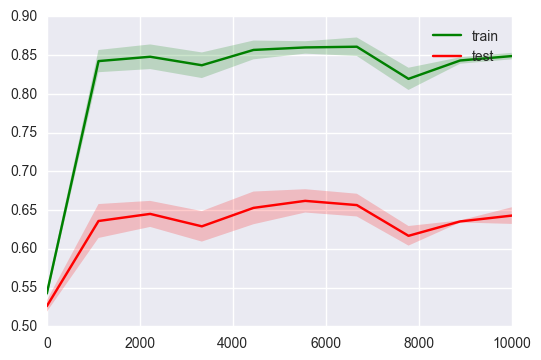

In [84]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C. **

**С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [22]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 30.6 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [88]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)

0.737278881852 {'C': 0.069896551724137931}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

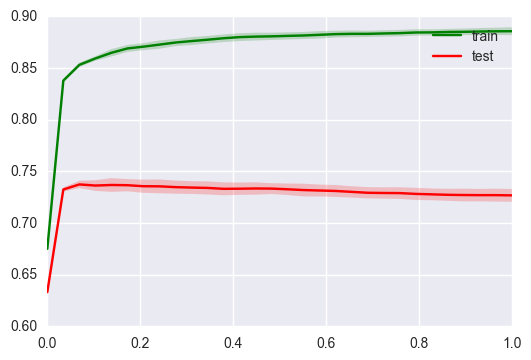

In [89]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке (X_valid, y_valid) для LinearSVC с лучшим найденным значением C.

In [90]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

In [91]:
svm_cv_acc

0.76184411614875192

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [92]:
write_answer_to_file("{} {}".format(round(svm_grid_searcher2.best_score_, 3), 
                                    round(svm_cv_acc, 3)),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации C.**

**Определите функцию model_assessment, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с train_test_split должно быть стратифицированным. Не теряйте нигде random_state.**

In [25]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, 
                     random_state=7, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    t_start = time()
    # Loading data
    with open(path_to_X_pickle, 'rb') as fid:
        X_sparse = pickle.load(fid)
    with open(path_to_y_pickle, 'rb') as fid:
        y = pickle.load(fid)
    #print(X_sparse.shape)
    # Spliting on train and validation
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state,
                                                          stratify=y)
    
    # Cross_validation extimation
    scores = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    # Model fitting
    estimator.fit(X_train, y_train)
    # Accuracy score on validation set
    acc_score = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return scores.mean(), acc_score, time() - t_start

**Убедитесь, что функция работает.**

In [26]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 'capstone_websites_data/X_sparse_10users.pkl',
                 'capstone_websites_data/y_10users.pkl', skf, random_state=7, test_size=0.3)

(0.73727543146114261, 0.76184411614875192, 2.1619999408721924)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, svm\_grid\_searcher2.best\_estimator\_) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем скромном маке этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = 'capstone_websites_data/X_sparse_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_websites_data/y_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3))

Session length: 15, Window size: 10
(0.80436299001715328, 0.82271944922547335, 3.1539998054504395)
Session length: 10, Window size: 10


**Запишите в файл *answer4_5.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_10users_s15_w5*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [103]:
cv_score, accur_score, _ = model_assessment(svm_grid_searcher2.best_estimator_, 
                                     'capstone_websites_data/X_sparse_10users_s15_w5.pkl',
                                     'capstone_websites_data/y_10users_s15_w5.pkl', skf, random_state=7, test_size=0.3)

In [106]:
print(cv_score, accur_score)

0.853099195254 0.854840709062


In [104]:
write_answer_to_file("{} {}".format(round(cv_score,3), round(accur_score,3)), 
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [108]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = 'capstone_websites_data/X_sparse_150users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_websites_data/y_150users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3)) 

Session length: 5, Window size: 5
(0.36404389655716818, 0.37600694882248281, 173.4190001487732)
Session length: 7, Window size: 7
(0.39783864020327425, 0.41213569918175968, 156.85199999809265)
Session length: 10, Window size: 10
(0.42888083119131698, 0.44566214700784995, 174.4779999256134)
Wall time: 8min 24s


**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [110]:
write_answer_to_file("{} {}".format(round(0.42888083119131698,3), round(0.44566214700784995,3)), 
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 10 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [111]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [112]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                                      random_state=7, stratify=y_150users)

**Обучите LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент multi_class='ovr'. Как всегда, где возможно, указывайте n_jobs=-1 и random_state=7.**

In [163]:
C_opt = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]
C_opt2 = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]
C_opt

0.68996551724137933

In [165]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[C_opt], cv=skf, random_state=7, n_jobs=-1, multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 13min 23s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [166]:
cv_scores_by_user = logit_cv_150users.scores_
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))

User 515, CV score: 0.99409047725
User 2902, CV score: 0.996668361549
User 6, CV score: 0.995739972451
User 13, CV score: 0.996198851281
User 15, CV score: 0.994920630834
User 16, CV score: 0.991316609688
User 533, CV score: 0.993642853621
User 28, CV score: 0.989404915446
User 1054, CV score: 0.996340828337
User 31, CV score: 0.994243565885
User 33, CV score: 0.993282117551
User 1371, CV score: 0.992987298385
User 39, CV score: 0.987111062147
User 46, CV score: 0.997837373236
User 49, CV score: 0.995106508496
User 50, CV score: 0.994407431058
User 563, CV score: 0.996810505172
User 564, CV score: 0.995576407317
User 53, CV score: 0.993445903193
User 568, CV score: 0.992342985128
User 569, CV score: 0.989710501739
User 570, CV score: 0.998132336024
User 573, CV score: 0.990934028864
User 575, CV score: 0.989808407812
User 576, CV score: 0.994418415621
User 65, CV score: 0.996810578675
User 66, CV score: 0.994593271385
User 580, CV score: 0.985865483721
User 2118, CV score: 0.9972473862

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [167]:
np.bincount(y_train_150.astype('int')).shape

(2903L,)

In [197]:
(class_distr.sum() - class_distr[6])/class_distr.sum()

0.98814855270344071

In [194]:
class_distr[128]

1638

In [184]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    val = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(val)
    acc_diff_vs_constant.append(cv_scores_by_user[user_id].mean() - val)
    print("User: {} difference: {}".format(user_id, cv_scores_by_user[user_id].mean() -\
                                           val))

0.988148552703
User: 6 difference: 0.00759141974769
0.995565264883
User: 13 difference: 0.00063358639808
0.994232659749
User: 15 difference: 0.000687971085365
0.984128891316
User: 16 difference: 0.0071877183716
0.987777170945
User: 28 difference: 0.00162774450162
0.994254505735
User: 31 difference: -1.09398496981e-05
0.992408519934
User: 33 difference: 0.000873597616501
0.984980884762
User: 39 difference: 0.00213017738451
0.99698525396
User: 46 difference: 0.000852119276796
0.993719279082
User: 49 difference: 0.00138722941311
0.994287274713
User: 50 difference: 0.000120156344894
0.991927908247
User: 53 difference: 0.00151799494662
0.996788640087
User: 65 difference: 2.19385877398e-05
0.994625887493
User: 66 difference: -3.26161083155e-05
0.996187875478
User: 82 difference: -7.65280126226e-05
0.996034953577
User: 85 difference: 1.08644870733e-05
0.989819770617
User: 89 difference: 0.000437054225466
0.994516657564
User: 92 difference: 0.000174708356204
0.995040961223
User: 100 difference

In [139]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

AttributeError: 'list' object has no attribute 'values'

In [185]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()
num_better_than_default

125

In [186]:
len(acc_diff_vs_constant)

150

In [187]:
num_better_than_default/150

0.83333333333333337

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [188]:
write_answer_to_file(round(float(num_better_than_default/150), 3), 
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конткретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [196]:
y_binary_128 = y_150users == 128
y_binary_128.astype('int')

2340

In [199]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [200]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, 
                                              X_sparse_150users, y_binary_128, 
                                              train_sizes=train_sizes, 
                                              cv=skf, 
                                              n_jobs=-1)

Wall time: 10.3 s


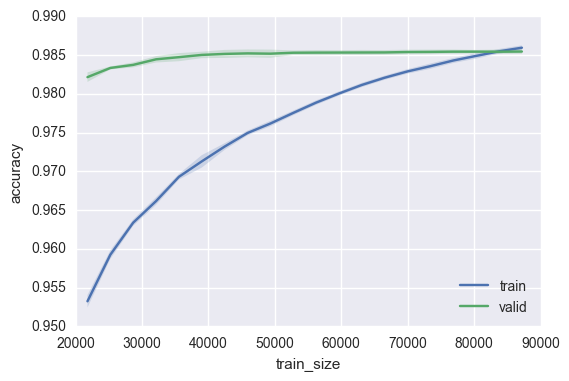

In [201]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (.ipynb или pdf) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревнование](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt) Kaggle Inclass.